In [1]:
import os
import argparse
import pandas as pd
import numpy as np


from sklearn.model_selection import train_test_split
import skimage.io as io 
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
%matplotlib inline

import keras
import keras.backend as K
from keras.models import load_model
from func import * 

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#### parser
parser = argparse.ArgumentParser()
parser.add_argument('-d' ,'--data', type=str, default='/home/katieyth/gynecology/data/data_cmu_ctu.csv', help='data')
# parser.add_argument('-s' ,'--model_save', type=str, default='/home/katieyth/gynecology/model_save/', help='model save path')
parser.add_argument('-y' ,'--target', type=str, default='multi', help='prediction target')
# # variability	UA	 deceleration management

# # input parameter
# parser.add_argument('-th','--acceptable_zeros_threshold', type=float, default=200, help='acceptable number of missing values in raw data')
# parser.add_argument('-l' ,'--length', type=int, default=600, help='length of input')
# parser.add_argument('-ks','--k_slice', type=int, default=1, help='a input will be sliced into k_slice segments when testing')
# parser.add_argument('-c' ,'--n_channel', type=int, default=2, help='number of input channels')
# parser.add_argument('-rn','--random_noise', type=int, default=0, help='add Gaussian noise (mean=0, std=0.01) into inputs')
# parser.add_argument('-nm','--normalized', type=int, default=1, help='whether conduct channel-wise normalization')
# parser.add_argument('-fb' ,'--force_binary', type=int, default=0, help='force to binary task')
parser.add_argument('-ctu_cmu' ,'--ctu_cmu', type=str, default='cmu', help='train_ctu_test_cmu')
parser.add_argument('-multi_task' ,'--multi_task', type=int, default=1, help='multi-task')




# # data augmentation 
# parser.add_argument('-aug_fliplr' ,'--aug_fliplr', type=int, default=0, help='reverse time series')
# parser.add_argument('-shift' ,'--DA_Shift', type=int, default=1, help='')
# parser.add_argument('-scale' ,'--DA_Scale', type=int, default=1, help='')
# parser.add_argument('-randsamp' ,'--DA_RandSampling', type=int, default=1, help='')


# # model parameters
# parser.add_argument('-struc' ,'--struc', type=str, default='deeper', help='deeper or shallower')
# parser.add_argument('-k' ,'--kernel_size', type=int, default=3, help='kernel size')
# parser.add_argument('-f' ,'--filters', type=int, default=64, help='base number of filters')
# parser.add_argument('-ly' ,'--layers', type=int, default=10, help='number of residual layers')
# parser.add_argument('-a' ,'--activation', type=str, default='relu', help='activation function')
# parser.add_argument('-i' ,'--kernel_initializer', type=str, default='RandomNormal', help='kernel initialization method')
# parser.add_argument('-l2','--l2', type=float, default=0.01, help='coefficient of l2 regularization')

# # hyper-parameters
# parser.add_argument('-lr','--learning_rate', type=float, default=1e-4, help='learning_rate')
# parser.add_argument('-reduce_lr_patience','--reduce_lr_patience', type=int, default=50, help='reduce_lr_patience')
# parser.add_argument('-bs','--batch_size', type=int, default=16, help='batch_size')
# parser.add_argument('-ep','--epoch', type=int, default=1500, help='epoch')
parser.add_argument('-wb','--weight_balance', type=int, default=0, help='whether weight balancing or not')
# parser.add_argument('-mntr','--monitor', type=str, default='val_man_acc', help='val_acc or val_loss')


# parser.add_argument('-g' ,'--gpu_id', type=str, default='7', help='GPU ID')
parser.add_argument('-rs' ,'--random_state', type=int, default=13, help='random state when train_test_split')
# parser.add_argument('-fn' ,'--summary_file', type=str, default=None, help='summary filename')


FLAG = parser.parse_args([])

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

# Data prepare

In [4]:
def data_preprocess_test(Xvalid, Yvalid,  length=600, class_weight = {}):

    Xtest = np.empty((Xvalid.shape[0], length, Xvalid.shape[2]))
    for i in range(Xvalid.shape[0]):
        # print(st+i)
        Xtest[i,:,:] = data_normalize(Xvalid[i,0:600,:])
    if not class_weight:
        class_weight = []
        for c in range(4):
            weight = dict()
            for i in range(Yvalid[c].shape[1]):
                weight[i] = 1
            class_weight.append(weight)
    Ytest = Yvalid
    return Xtest, Ytest, class_weight

In [5]:
d = pd.read_csv(os.path.join(FLAG.data))
# d = d[myutils.get_n_zeros(np.array(d[[k for k in d.columns if 'b-' in k]], dtype=np.float)) <= FLAG.acceptable_zeros_threshold]

# if FLAG.force_binary : 
#     d[d[FLAG.target]>1] = 1
# n_classes = 4#len(set(d[FLAG.target]))

# replace 0 (no readings) with np.nan for later substitution
for k in d.columns:
    if 'b-' in k or 'm-' in k:
        print(k, end='\r')
        d.loc[d[k]==0, k] = np.nan

if FLAG.ctu_cmu == 'trans':
    train_d = d[d['ID'].str.contains('CTU_')]
    valid_d = d[d['ID'].str.contains('CMU_')]
elif FLAG.ctu_cmu == 'mix':
    train_d,valid_d = train_test_split(d, test_size=0.3, random_state=FLAG.random_state, stratify =d['management'])
elif FLAG.ctu_cmu == 'cmu':
    dd = d[d['ID'].str.contains('CMU_')]
    train_d,valid_d = train_test_split(dd, test_size=0.3, random_state=FLAG.random_state, stratify =dd['management'])
elif FLAG.ctu_cmu == 'trans_inv':
    train_d = d[d['ID'].str.contains('CMU_')]
    valid_d = d[d['ID'].str.contains('CTU_')]
    
    
# interpolate missing values
train_db = np.array(train_d[[k for k in train_d.columns if 'b-' in k]].interpolate(limit_direction='both', axis=1), dtype=np.float)
train_dm = np.array(train_d[[k for k in train_d.columns if 'm-' in k]].interpolate(limit_direction='both', axis=1), dtype=np.float)

valid_db = np.array(valid_d[[k for k in valid_d.columns if 'b-' in k]].interpolate(limit_direction='both', axis=1), dtype=np.float)
valid_dm = np.array(valid_d[[k for k in valid_d.columns if 'm-' in k]].interpolate(limit_direction='both', axis=1), dtype=np.float)

# combine signals from baby and mom
Xtrain = np.stack([train_db, train_dm], axis=2)
Xvalid = np.stack([valid_db, valid_dm], axis=2)

# convert labels to one-hot encodings
if FLAG.multi_task:
    Ytrain_man = keras.utils.to_categorical(np.array(train_d['management']),   num_classes=3)#len(set(np.array(train_d['management']))))
    Ytrain_ua  = keras.utils.to_categorical(np.array(train_d['UA']),           num_classes=2)#len(set(np.array(train_d['UA']))))
    Ytrain_var = keras.utils.to_categorical(np.array(train_d['variability']),  num_classes=2)#len(set(np.array(train_d['variability']))))
    Ytrain_dec = keras.utils.to_categorical(np.array(train_d['deceleration']), num_classes=4)#len(set(np.array(train_d['deceleration']))))
    Ytrain = [Ytrain_man, Ytrain_ua, Ytrain_var, Ytrain_dec]

    Yvalid_man = keras.utils.to_categorical(np.array(valid_d['management']),   num_classes=3)#len(set(np.array(train_d['management']))))
    Yvalid_ua  = keras.utils.to_categorical(np.array(valid_d['UA']),           num_classes=2)#len(set(np.array(train_d['UA']))))
    Yvalid_var = keras.utils.to_categorical(np.array(valid_d['variability']),  num_classes=2)#len(set(np.array(train_d['variability']))))
    Yvalid_dec = keras.utils.to_categorical(np.array(valid_d['deceleration']), num_classes=4)#len(set(np.array(train_d['deceleration']))))
    Yvalid = [Yvalid_man, Yvalid_ua, Yvalid_var, Yvalid_dec]
    #weight balancing or not
    if FLAG.weight_balance:
        weight_list = []
        for i in range(4):
            y_integers = np.argmax(Ytrain[i], axis=1)
            d_class_weight = compute_class_weight('balanced', np.unique(y_integers), y_integers)
            class_weight = dict(enumerate(d_class_weight))
            print('class weight: {0}'.format(class_weight))
            weight_list.append(class_weight)
    else:
        weight_list = []
        
        for c in [3,2,2,4]:
            class_weight = dict()
            for i in range(c):
                class_weight[i] = 1
            weight_list.append(class_weight)

else:
    Ytrain = keras.utils.to_categorical(np.array(train_d[FLAG.target]), num_classes=n_classes)
    Yvalid = keras.utils.to_categorical(np.array(valid_d[FLAG.target]), num_classes=n_classes)
    #weight balancing or not
    if FLAG.weight_balance:

        y_integers = np.argmax(Ytrain, axis=1)
        d_class_weight = compute_class_weight('balanced', np.unique(y_integers), y_integers)
        class_weight = dict(enumerate(d_class_weight))
        print('class weight: {0}'.format(class_weight))
    else:
        class_weight = dict()
        for i in range(n_classes):
            class_weight[i] = 1



Xtest, Ytest, Wtest =data_preprocess_test(Xvalid, Yvalid, class_weight = weight_list)
#print(Wtest)
# print(Xtest.shape)
# print(Xtest[0:5])
# class weight: {0: 0.5892575039494471, 1: 1.0626780626780628, 2: 2.762962962962963}
# class weight: {0: 0.6411764705882353, 1: 1.09, 2: 1.912280701754386}

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (8,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
Xtrain, Ytrain, Wtest =data_preprocess_test(Xtrain, Ytrain, class_weight = weight_list)

# Define func

In [7]:
# get gradient
def get_grad(model, model_pred, tg_position, grad_layer):
    '''get_grad(model = trained_model,
                model_pred = pred,
                tg_position = tg_dict[tg],
                grad_layer = 'conv1d_25') '''
    prd_cls = np.argmax(pred[tg_position], axis = 1)
    # 只有一個dim，所以取0那個dim，再指定 model 預測的 class (不是 G-true label)
    y_c = model.output[tg_position][0,prd_cls]
    # 選最後一個 conv layer 作為要取 gradient 的位置
    conv_layer = model.get_layer(grad_layer).output
    # tf.gradients()
    grads = K.gradients(y_c, conv_layer)[0]
    gradient_function = K.function([model.input], [conv_layer, grads])
    ###### flow to the graph and get *target layer and * corresponding gradient
    conv_output, grads_val = gradient_function([ctg_x])
    
    return conv_output, grads_val

In [8]:
# follow paper method (Grad-CAM)
def GCAM(feature_map, Fmap_grad):
    '''GCAM(feature_map = conv_output,
            Fmap_grad = grads_val)'''
    ### (1,10,192) feature map size: (1,10) feature map num: 192 
    ### get mean gradients for each feature map as its weight
    weights = np.mean(Fmap_grad, axis = (0, 1))
    ### multiply each F_map by its corresponding weight
    for i, w in enumerate(weights):  
            feature_map[:, :, i] *= w 
    ### sum each feature point by point to get 'global weight' (1:10) 
    hightlight_fmap = np.sum(feature_map, axis=2)
    ### passing relu, we only concern those with positive reponse to model's prediction
    hightlight_fmap_relu = np.maximum(hightlight_fmap, 0) 
    
    
    return hightlight_fmap_relu[0]

In [9]:
# get material for visualizing 1D Grad-CAM
def get_material_vis_by_tg(model, tg_position, pred):
    ''' get_material_vis_by_tg(model = trained_model,
                               tg_position = tg_dict[tg],
                               pred = pred)'''
    conv_output, grads_val = get_grad(model = model,
                                  model_pred = pred,
                                  tg_position = tg_position,
                                  grad_layer = 'conv1d_25')
    hightlight_fmap_relu = GCAM(feature_map = conv_output,
                                Fmap_grad = grads_val)
#     HL_extend = np.repeat(hightlight_fmap_relu, 60)
#     HL_extend = np.expand_dims(HL_extend, axis = 0)
    x_axis = [i for i in range(600)]
    
    return x_axis, hightlight_fmap_relu

In [10]:
# create grid: 4 2-pairs
def create_grid():
    n = 4 # number of double-rows
    m = 1 # number of columns

    t = 0.9 # 1-t == top space 
    b = 0.1 # bottom space      (both in figure coordinates)

    msp = 0.1 # minor spacing
    sp = 0.5  # major spacing

    offs=(1+msp)*(t-b)/(2*n+n*msp+(n-1)*sp) # grid offset
    hspace = sp+msp+1 #height space per grid

    gso = GridSpec(n,m, bottom=b+offs, top=t, hspace=hspace)
    gse = GridSpec(n,m, bottom=b, top=t-offs, hspace=hspace)

    fig = plt.figure(figsize=(10,6))
    axes1 = []
    axes2 = []
    for i in range(n*m):
        axes1.append(fig.add_subplot(gso[i]))
        axes2.append(fig.add_subplot(gse[i]))
    return fig, axes1, axes2

# Visulize 1D Grad-CAM

In [11]:
tg_dict = {'man':0,
          'ua':1,
          'var':2,
          'dec':3}
tg_list = ['Management',
          'UA',
          'Variability',
          'Deceleration']

In [12]:
model_pstn = 'model_save/multi/multi_190104161240/' 
model_path = os.path.join('/home/katieyth/gynecology/', model_pstn)
trained_model = load_model(os.path.join(model_path,'model.h5'))


deal_Xset = Xtest
deal_Yset = Ytest
deal_ID = valid_d.ID
save_dir = os.path.join(model_pstn, 'GCAM_1D/test_conv25')

In [13]:
# kk = np.expand_dims(hightlight_fmap_relu, axis=0)
# plt.imshow(kk, cmap = 'coolwarm')
# plt.axis('off')

In [14]:
deal_ID[0:1]

81    CMU_363194_67380
Name: ID, dtype: object

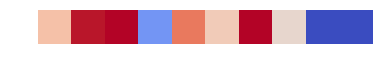

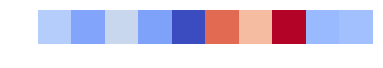

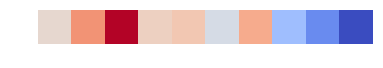

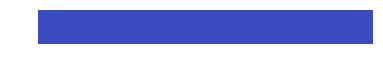

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in float_scalars
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in float_scalars


In [15]:
for idx, ID in enumerate(deal_ID[0:1]):
    ctg_x = np.expand_dims(deal_Xset[idx], axis=0)

    ctg_y_man = np.argmax(deal_Yset[0][idx])
    ctg_y_ua  = np.argmax(deal_Yset[1][idx])
    ctg_y_var = np.argmax(deal_Yset[2][idx])
    ctg_y_dec = np.argmax(deal_Yset[3][idx])
    ctg_y = [deal_Yset[0][idx],
             deal_Yset[1][idx],
             deal_Yset[2][idx],
             deal_Yset[3][idx]]
    pred = trained_model.predict(ctg_x)
    
    fig, axes1, axes2 = create_grid()
    for od, tg_name in enumerate(['man', 'ua', 'var', 'dec']):
        x_axis, hightlight_fmap_relu \
        = get_material_vis_by_tg(model = trained_model,
                                 tg_position = tg_dict[tg_name],
                                 pred = pred)
        plt.close(fig)
        kk = np.expand_dims(hightlight_fmap_relu, axis=0)
        plt.imshow(kk, cmap = 'coolwarm')
        plt.axis('off')
        plt.show()
        
        
        pred_prob = [int(v*100) for v in pred[od][0]]
        true_prob = [int(v) for v in ctg_y[od]]


        ax = axes1[od]
        for i in range(len(hightlight_fmap_relu)):
            local_max = max(hightlight_fmap_relu) # temporary, should get global max in the future (?)
            ax.plot(x_axis[i*60:(i+1)*60],
                     ctg_x[0][i*60:(i+1)*60,0], # baby
                     color = cm.coolwarm(hightlight_fmap_relu[i]/local_max))
        ax.set_xticks([], [])
        ax.set_yticks([], [])
        if tg_name == 'man':
            ax.set_title('◉  '+tg_list[od] + '    #ID: %s' %(ID), x = 0, loc = 'left')
        else:
            ax.set_title('◉  '+tg_list[od], x = 0, loc = 'left')
        
        ax.yaxis.set_label_position("right")
        ax.set_ylabel('True Label\n  %s\n'%(true_prob)+\
                      'Model Confidence (%)'+'\n  %s' %(pred_prob),
                      fontsize=10, rotation = 0,
                      horizontalalignment='left',
                      position=(0,1))

        ax = axes2[od]
        for i in range(len(hightlight_fmap_relu)):
            local_max = max(hightlight_fmap_relu) # temporary, should get global max in the future (?)
            ax.plot(x_axis[i*60:(i+1)*60],
                    ctg_x[0][i*60:(i+1)*60,1], # mommy
                    color = cm.coolwarm(hightlight_fmap_relu[i]/local_max))
        ax.set_xticks([], [])
        ax.set_yticks([], [])
    check_dir(save_dir)
#     fig.savefig(os.path.join(save_dir, '%s.png' % (ID)), dpi=150, bbox_inches='tight')
#     plt.close(fig)
    print( '%d/%d' %(idx, len(deal_Xset)), end='\r')

# annotate color bar ( Not REQUIRED )

In [16]:
deal_p = os.listdir(save_dir)
c_bar = io.imread('./Screenshot from 2019-01-09 15-03-40.png')
for idx, fname in enumerate(deal_p):
    fig2 = plt.figure(figsize=(10,6), dpi = 200)
    outer_grid = GridSpec(2,1, height_ratios=[1, 20],
                         hspace=0)
    ax0 = fig2.add_subplot(outer_grid[0])

    ax0.annotate('⇦ Lower Response', xy=(200,23), xytext=(20, 23), size = 8, color= 'white')
    ax0.annotate('Higher Response ⇨', xy=(200,23), xytext=(400, 23), size = 8, color= 'white')
    ax0.imshow(c_bar[:31,:,:])
    ax0.axis('off')

    ax1 = fig2.add_subplot(outer_grid[1])
    p_signal = io.imread(os.path.join(save_dir, fname))
    ax1.imshow(p_signal[10:,10:,:])
    ax1.axis('off')
    fig2.savefig(os.path.join(save_dir, fname), dpi=200, bbox_inches='tight')
    plt.close(fig2)
    print( '%d/%d' %(idx, len(deal_p)), end='\r')